# Eigenfaces

The technique of eigenfaces is an application of PCA to human facial images. Identification and recognition of human faces is easy for us because we are hardwired to do so, but it is not as straightforward for a machine to replicate these tasks. In addition to different faces having different appearances, images can also vary in quality, lighting, viewpoint, etc. So one approach is to try to extract a small set of "basis faces" from a set of facial images. These represent the basic ingredients of human faces and can be used to analyze future faces and images.

This project is based on the one from SciPy Lectures on eigenfaces, accessible here: https://scipy-lectures.org/packages/scikit-learn/auto_examples/plot_eigenfaces.html. The dataset is taken by hand. The first 15 images are displayed below.

shape of dictionary(#images, image size) (188, 64, 64)


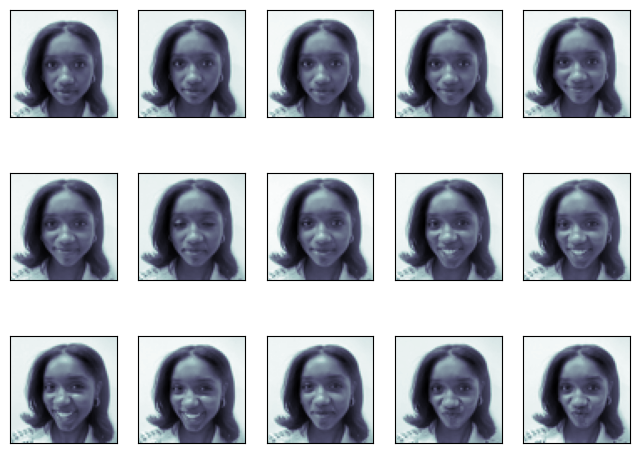

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pickle
import os
import sklearn
import json
import cv2


#faces = pickle.load(open("sample.json", 'rb'))
f = open('campbell-1.json')
b = open('campbell-1.json')
w = open('ashley-1.json')
y = open('Ava-1.json')
z = open('tierney-1.json')

faces = json.load(w)
facesCampbell = json.load(b)
#facesAshley = json.load(w)
facesAva = json.load(y)
facesTierney = json.load(z)


#faces['images'].extend(facesAshley['images'])
faces['images'].extend(facesAva['images'])
faces['images'].extend(facesTierney['images'])


print('shape of dictionary(#images, image size)',np.shape(faces['images']))
# display first 15 images
fig = plt.figure(figsize=(8, 6))
for i in range(15):
  ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  ax.imshow(faces['images'][i], cmap=plt.cm.bone)

The first step of PCA is to demean the data. So we form the $n \times p = 232 \times 4096$ data matrix $X$ and compute the "mean face". Each row represents a single image, whose 4096 pixels are reshaped into a row vector. Values indicate the brightness of each pixel.

Mean Overall Face


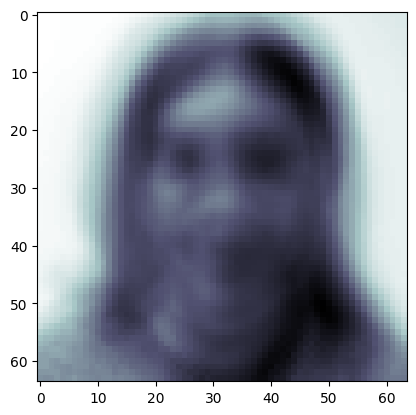

In [3]:
n = len(faces['images'])
imsize = (len(faces['images'][0]), len(faces['images'][0][0]))
p = imsize[0]*imsize[1]
X = np.empty((n,p))

# form nxp data matrix, with each image as a row vector
for i in range(n):
  X[i,:] = np.reshape(faces['images'][i], p)

# compute and display mean image
mean = np.mean(X, axis=0)
mean = mean.astype(np.uint8)

print("Mean Overall Face")
plt.imshow(np.reshape(mean, imsize), cmap=plt.cm.bone)
plt.show()

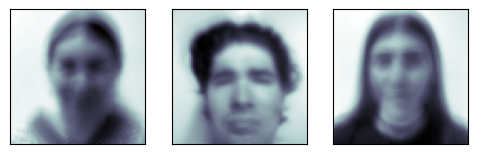

In [46]:

def avgFace(dict):
  n= len(dict['images'])
  imsize = (len(dict['images'][0]), len(dict['images'][0][0]))
  p = imsize[0]*imsize[1]
  X = np.empty((n,p))

  # form nxp data matrix, with each image as a row vector
  for i in range(n):
    X[i,:] = np.reshape(dict['images'][i], p)
  
  # compute mean image
  mean = np.mean(X, axis=0)
  mean = mean.astype(np.uint8)
  return X, mean


fig = plt.figure(figsize=(8, 8))


#Display mean image of Ashley
#ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
#A , meanA = avgFace(facesAshley)
#ax.imshow(np.reshape(meanA, imsize), cmap=plt.cm.bone)

ax = fig.add_subplot(1, 4, 2, xticks=[], yticks=[])
AV , meanAv = avgFace(facesAva)
ax.imshow(np.reshape(meanAv, imsize), cmap=plt.cm.bone)

ax = fig.add_subplot(1, 4, 3, xticks=[], yticks=[])
C , meanC = avgFace(facesCampbell)
ax.imshow(np.reshape(meanC, imsize), cmap=plt.cm.bone)

ax = fig.add_subplot(1, 4, 4, xticks=[], yticks=[])
T , meanT = avgFace(facesTierney)
ax.imshow(np.reshape(meanT, imsize), cmap=plt.cm.bone)

plt.show()

Note that $p$ is much larger than $n$. This is an instance of PCA where it is advantageous to work with the SVD of $X$ rather than computing the much larger covariance matrix.

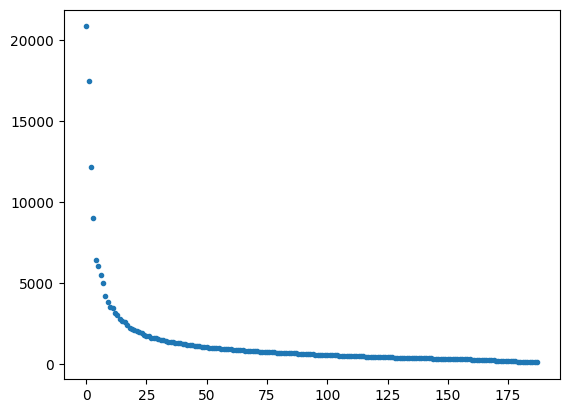

In [5]:
# compute SVD and show singular values
X -= mean
U, s, VT = np.linalg.svd(X)
plt.plot(s, '.')
plt.show()

From our scree plot of the singular values (proportional to the square roots of the variances), we see that most of them are relatively small compared to the first 50 or so values. This suggests that can possibly get away with using around this number of "eigenfaces" to represent images in the original dataset, and potentially other images as well.

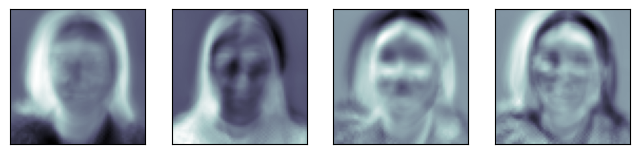

(4096, 4096)
[1963.11617783 1401.83847335 -657.74762147 ...   27.97359443   70.44262533
  -35.2325607 ] (4096,)


In [6]:
# show the first four eigenfaces
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 4, 1, xticks=[], yticks=[])
ax.imshow(np.reshape(VT[0,:], imsize), cmap=plt.cm.bone)
ax = fig.add_subplot(1, 4, 2, xticks=[], yticks=[])
ax.imshow(np.reshape(VT[1,:], imsize), cmap=plt.cm.bone)
ax = fig.add_subplot(1, 4, 3, xticks=[], yticks=[])
ax.imshow(np.reshape(VT[2,:], imsize), cmap=plt.cm.bone)
ax = fig.add_subplot(1, 4, 4, xticks=[], yticks=[])
ax.imshow(np.reshape(VT[3,:], imsize), cmap=plt.cm.bone)
plt.show()
print(np.shape(VT))


img = cv2.imread('TestDist.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Resize the image to the same size as the training images
gray = cv2.resize(gray, (64, 64))

# Flatten the image into a 1D vector
vector = np.asarray(gray)
vector = vector.flatten()

# Subtract the mean face from the image vector
vector -= mean

# Project the image vector onto the eigenfaces to obtain the weights
weights = np.dot(VT, vector)

print(weights, np.shape(weights))


We can actually plot out the first few eigenfaces to understand what they look like. While a bit disturbing to look at, these images do show us some features that may be common across many images. In the first one we see some definition of hair and brow. The third one shows the cheeks and forehead shine capturing a overhead lighting source. The last image shows a shine on the forehead skin coming from light on the right side. 

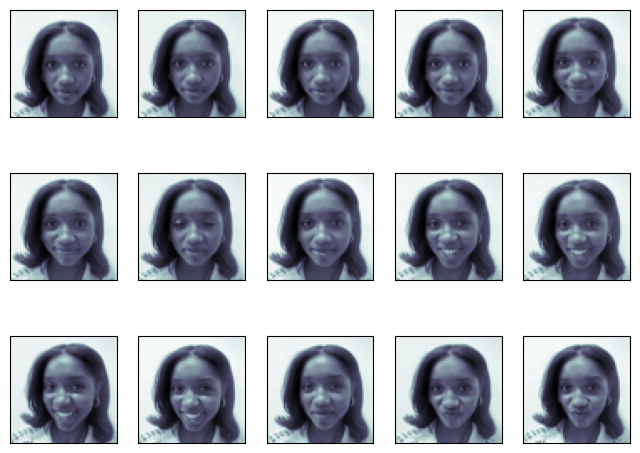

In [7]:
# coordinates of X in first k PCs -> nxk matrix
k = 200
T = X @ VT.T[:,:k]

# plot the rank-k approximations of original images
# remember to add mean image back before plotting
fig = plt.figure(figsize=(8, 6))
for i in range(15):
  ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  rank_k_image = T[i,:] @ VT[:k,:]
  ax.imshow(np.reshape(rank_k_image + mean, imsize), cmap=plt.cm.bone)

Distance CalculationsImplemenented Below

In [50]:
#Euclidean distance between the list of weightings vs. the 
#average weigting for a person.
def euclidDist(target, reference):
    n = len(target)
    
    internalSum = 0

    for i in range(n):
        internalSum += np.square(reference[i]-target[i])

    dist =  np.sqrt(internalSum)

    return dist

def absoluteDist(target, reference):
    n = len(target)
    
    internalSum = 0

    for i in range(n):
        internalSum += np.abs(reference[i]-target[i])

    dist =  np.sqrt(internalSum)

    return dist

In [83]:
#Find the average weighting for a person to using in facial recognition
def meanWeight(json_file, meanFace, eigenfaces):
    
    total = np.zeros((len(eigenfaces),))
    n = len(json_file['images'])
    for im in json_file['images']:
        vector = np.array(im).flatten()
    
        # Subtract the mean face from the image vector
        vector -= meanFace

        # Project the image vector onto the eigenfaces to obtain the weights
        weights = np.dot(eigenfaces, vector)
        total = np.array(total) + np.array(weights)
    
    mean = total / n
    return mean

        


In [84]:
meanAvaWeight = meanWeight(facesAva,mean,VT)

meanTierneyWeight = meanWeight(facesTierney,mean,VT)
meanCampbellWeight = meanWeight(facesCampbell,mean,VT)


In [85]:
testTierney = cv2.imread('TestImages\IMG_8640.JPG')

gray = cv2.cvtColor(testTierney, cv2.COLOR_BGR2GRAY)

# Resize the image to the same size as the training images
gray = cv2.resize(gray, (64, 64))

# Flatten the image into a 1D vector
vector = np.asarray(gray)
vector = vector.flatten()

# Subtract the mean face from the image vector
vector -= mean

# Project the image vector onto the eigenfaces to obtain the weights
TestWeights = np.dot(VT, vector)

In [86]:
#euclidean distance
print("Euclidean distance calculation")
print(euclidDist(TestWeights,meanAvaWeight))
print(euclidDist(TestWeights,meanTierneyWeight))
print(euclidDist(TestWeights,meanCampbellWeight))

#absolute distance
print("\nAbsolute distance calculation")
print(absoluteDist(TestWeights,meanAvaWeight))
print(absoluteDist(TestWeights,meanTierneyWeight))
print(absoluteDist(TestWeights,meanCampbellWeight))

Euclidean distance calculation
8615.961751047298
10052.51305270035
9572.31905600186

Absolute distance calculation
547.1501850116388
549.9705819554786
560.5199941389341


In [75]:
testCampbell = cv2.imread('TestImages\IMG_8801.JPG')

gray = cv2.cvtColor(testCampbell, cv2.COLOR_BGR2GRAY)

# Resize the image to the same size as the training images
gray = cv2.resize(gray, (64, 64))

# Flatten the image into a 1D vector
vector = np.asarray(gray)
vector = vector.flatten()

# Subtract the mean face from the image vector
vector -= mean

# Project the image vector onto the eigenfaces to obtain the weights
TestWeights = np.dot(VT, vector)

In [76]:
#euclidean distance
print("Euclidean distance calculation")
print(euclidDist(TestWeights,meanAvaWeight))
print(euclidDist(TestWeights,meanTierneyWeight))
print(euclidDist(TestWeights,meanCampbellWeight))

#absolute distance
print("\nAbsolute distance calculation")
print(absoluteDist(TestWeights,meanAvaWeight))
print(absoluteDist(TestWeights,meanTierneyWeight))
print(absoluteDist(TestWeights,meanCampbellWeight))

Euclidean distance calculation
9297.864873707114
9826.532745289125
10827.522337868937

Absolute distance calculation
600.7613468912058
603.583756399199
638.8628072524047
